In [2]:
%matplotlib inline

import pandas as pd
import psycopg2
import psycopg2.extras
import getpass
import datetime

appname = 'BigTextTesting-Ryan'

def get_db_string():
    database_string = 'postgresql://{user}:{pw}@{host}:{port}/{dbname}?application_name={appname}'
    db_name = input('Database name: ')
    db_user = input('Enter PgSQL username: ')
    db_pw = getpass.getpass('Enter password: ')
    db_host = input('Database host [127.0.0.1]: ') or '127.0.0.1'
    db_port = input('Database port [5432]: ') or '5432'
    
    return database_string.format(user=db_user, pw=db_pw, host=db_host,
                                  port=db_port, dbname=db_name, appname=appname)

print('Define connection for database...')
DB_STRING = get_db_string()

def get_db_conn():
    """Establish Database connection via psycopg2"""
    db_string = DB_STRING

    try:
        conn = psycopg2.connect(db_string)
    except psycopg2.OperationalError as err:
        err_msg = 'DB Connection Error - Error: {}'.format(err)
        print(err_msg)
        return False
    return conn

def run_sql_no_result(sql_raw, params=None):
    with get_db_conn() as conn:
        cur = conn.cursor()
        cur.execute(sql_raw, params)
        conn.commit()


Define connection for database...
Database name: big_text
Enter PgSQL username: rpl_db_admin
Enter password: ········
Database host [127.0.0.1]: 
Database port [5432]: 


In [4]:
sql_version = "select version();"
result = pd.read_sql(sql_version, get_db_conn())
result['version'][0]

'PostgreSQL 12.3 (Ubuntu 12.3-1.pgdg18.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit'

In [5]:
sql_create_tbl = """
DROP TABLE IF EXISTS dev_text.b%(base_length)s_v%(variance)s;
CREATE TABLE dev_text.b%(base_length)s_v%(variance)s
(
    id BIGINT NOT NULL GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY,
    val TEXT NOT NULL
);
"""

sql_populate_tbl = """
INSERT INTO dev_text.b%(base_length)s_v%(variance)s (val)
SELECT repeat(md5(random()::TEXT),
            %(base_length)s + ceil(random() * %(variance)s)::INT)
	FROM generate_series(1, %(row_count)s) x;
ANALYZE dev_text.b%(base_length)s_v%(variance)s
;
"""

sql_dd_table = """
SELECT rows, bytes_per_row, size_pretty, size_plus_indexes
    FROM dd.tables
    WHERE s_name = 'dev_text'
        AND t_name = 'b%(base_length)s_v%(variance)s'
;
"""

sql_stats_table = """
SELECT MIN(LENGTH(val)) AS len_min, AVG(LENGTH(val)) AS len_avg, MAX(LENGTH(val)) AS len_max
    FROM dev_text.b%(base_length)s_v%(variance)s;
"""

In [6]:
sql_recreate_schema = """
CREATE EXTENSION IF NOT EXISTS pgdd;
DROP SCHEMA IF EXISTS dev_text CASCADE;
CREATE SCHEMA dev_text;
"""
run_sql_no_result(sql_recreate_schema)

In [7]:
def load_text_tables(start_width=0, increment_multiplier=5, variance=25, tables_to_create=20, row_count=1000):
    target_rows = tables_to_create * row_count
    print(f'{tables_to_create} tables with {row_count} rows = {target_rows} total rows')
    stats = list()
    end = tables_to_create + start_width

    conn = get_db_conn()
    for i in range(start_width, end):
        table_stats = dict()
        table_stats['ix'] = i
        if i == start_width:
            base_length = i
        else:
            base_length = i * increment_multiplier
        
        if i % 5 == 0:
            print(f'Table {i} with base length: {base_length}...')

        params = {'base_length': base_length, 'variance': variance, 'row_count': row_count}
        run_sql_no_result(sql_create_tbl, params)

        s_time = datetime.datetime.now()
        run_sql_no_result(sql_populate_tbl, params)
        e_time = datetime.datetime.now()
        elapsed = e_time - s_time
        if i % 5 == 0:
            print(f'... load & analyze time: {elapsed} seconds (one table)')
        table_stats['base_length'] = base_length
        table_stats['variance'] = variance
        table_stats['load_time_s'] = elapse*:*:*:rpl_db_admin:yVPL35V5oVzyWX6GuEj9Nhc6SqG5XP
d

        dd_table = pd.read_sql(sql_dd_table, conn, params=params)
        table_stats['rows'] = dd_table['rows'][0]
        table_stats['bytes_per_row'] = dd_table['bytes_per_row'][0]
        table_stats['size_pretty'] = dd_table['size_pretty'][0]
        table_stats['size_plus_indexes'] = dd_table['size_plus_indexes'][0]

        stats_df = pd.read_sql(sql_stats_table, conn, params=params)
        table_stats['len_min'] = stats_df['len_min'][0]
        table_stats['len_avg'] = stats_df['len_avg'][0]
        table_stats['len_max'] = stats_df['len_max'][0]
        stats.append(table_stats)

    conn.close()
    
    df = pd.DataFrame(stats)
    df.set_index('ix')
    return df

def print_basic_stats(df):
    load_time = df['load_time_s'].sum()
    print(f'Total Data Load time: {load_time}')

    # Assumes all rows have same counts
    rows_cnt = int(df['rows'][0])
    print(rows_cnt)

In [8]:
def chart_bytes_per_row_vs_length(df):
    rows_cnt = int(df['rows'][0])
    chart_title = f"Bytes per Row vs. Text Length - {rows_cnt} rows/table"
    ax = df[['bytes_per_row', 'len_avg', 'base_length']].plot(x='base_length',
                                                              kind='bar',
                                                              title=chart_title,
                                                              figsize=(16, 8),
                                                              legend=True,
                                                              fontsize=16)
    return ax



In [12]:
default_stats = load_text_tables(row_count=10000)

20 tables with 10000 rows = 200000 total rows
Table 0 with base length: 0...
... load & analyze time: 0:00:00.359978 seconds (one table)
Table 5 with base length: 25...
... load & analyze time: 0:00:00.685202 seconds (one table)
Table 10 with base length: 50...
... load & analyze time: 0:00:00.760782 seconds (one table)
Table 15 with base length: 75...
... load & analyze time: 0:00:00.264974 seconds (one table)


In [13]:
print_basic_stats(default_stats)

Total Data Load time: 0 days 00:00:08.545112
10000


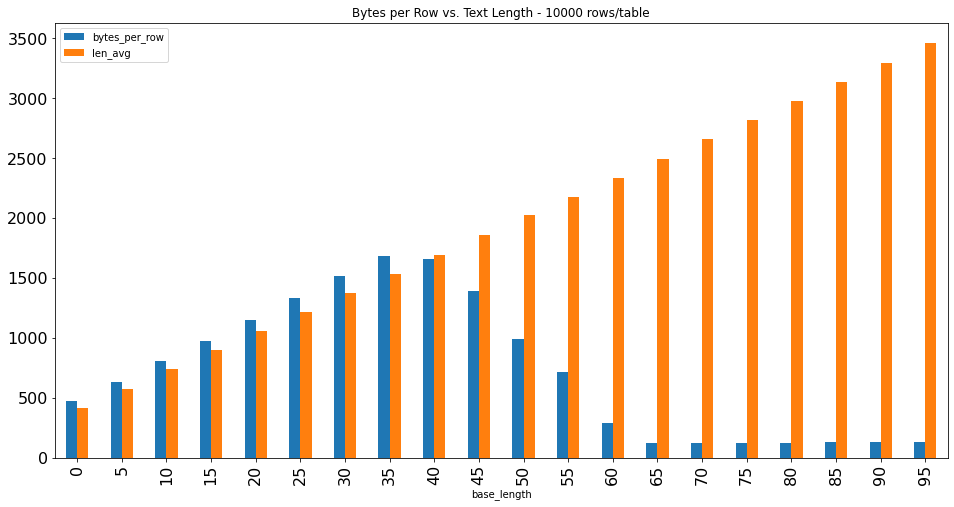

In [14]:
ax = chart_bytes_per_row_vs_length(default_stats)

In [16]:
default_stats

ix  base_length  variance     load_time_s     rows  bytes_per_row  \
0    0            0        25 00:00:00.359978  10000.0       468.5824   
1    1            5        25 00:00:00.565752  10000.0       634.0608   
2    2           10        25 00:00:00.215417  10000.0       808.5504   
3    3           15        25 00:00:00.516854  10000.0       973.2096   
4    4           20        25 00:00:00.531246  10000.0      1147.6992   
5    5           25        25 00:00:00.685202  10000.0      1328.7424   
6    6           30        25 00:00:00.269493  10000.0      1515.5200   
7    7           35        25 00:00:00.684894  10000.0      1679.3600   
8    8           40        25 00:00:00.733457  10000.0      1654.7840   
9    9           45        25 00:00:00.605026  10000.0      1386.9056   
10  10           50        25 00:00:00.760782  10000.0       988.7744   
11  11           55        25 00:00:00.270312  10000.0       711.0656   
12  12           60        25 00:00:00.242901  10000.0       284.2624   
13  13           65        25 00:00:00.455869  10000.0       119.6032   
14  14           70        25 00:00:00.258120  10000.0       120.4224   
15  15           75        25 00:00:00.264974  10000.0       122.8800   
16  16           80        25 00:00:00.243099  10000.0       124.5184   
17  17           85        25 00:00:00.291960  10000.0       126.1568   
18  18           90        25 00:00:00.275125  10000.0       127.7952   
19  19           95        25 00:00:00.314651  10000.0       129.4336   

   size_pretty size_plus_indexes  len_min    len_avg  len_max  
0      4576 kB           4816 kB       32   413.0560      800  
1      6192 kB           6432 kB      192   574.1440      960  
2      7896 kB           8136 kB      352   739.9104     1120  
3      9504 kB           9744 kB      512   894.0384     1280  
4        11 MB             11 MB      672  1055.1456     1440  
5        13 MB             13 MB      832  1217.1328     1600  
6        14 MB             15 MB      992  1376.9728     1760  
7        16 MB             16 MB     1152  1535.5616     1920  
8        16 MB             16 MB     1312  1693.6832     2080  
9        13 MB             13 MB     1472  1857.4144     2240  
10     9656 kB           9896 kB     1632  2021.6960     2400  
11     6944 kB           7184 kB     1792  2173.4240     2560  
12     2776 kB           3016 kB     1952  2334.0384     2720  
13     1168 kB           1408 kB     2112  2495.7824     2880  
14     1176 kB           1416 kB     2272  2658.0320     3040  
15     1200 kB           1440 kB     2432  2813.7952     3200  
16     1216 kB           1456 kB     2592  2977.9776     3360  
17     1232 kB           1472 kB     2752  3134.1088     3520  
18     1248 kB           1488 kB     2912  3292.2592     3680  
19     1264 kB           1504 kB     3072  3457.1264     3840